In [16]:
import os
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import pickle
import HALS.HALS as hals

plt.style.use('ggplot')
myColor  = ("#E3072A","#0A8974","#5FAECC","#E49C23","#E27520") # Darjeeling Color map

In [17]:
# Load results

path = 'Results/pkl_files/'

with open(path + 'strain_to_atm.pkl', 'rb') as f:
    data = pickle.load(f)
data.keys()

dict_keys(['B1', 'B2'])

In [18]:
# Earth tide frequencies
et_fqs = {'Q1': 0.893244, 'O1': 0.929536, 'M1': 0.966446, 'P1': 0.997262, 'S1': 1.0, 'K1': 1.002738, 'N2': 1.895982, 'M2': 1.932274, 'S2': 2.0, 'K2': 2.005476}

# Atmospheric tide frquencies
at_fqs = {'P1': 0.997262, 'S1': 1.0, 'K1': 1.002738, 'S2': 2.0, 'K2': 2.005476}



In [19]:
for key in data:

    # streamline the column format
    data[key].index = pd.to_datetime(data[key].index, dayfirst=True)

    # create a numeric value column
    dnum_col = pd.to_numeric(data[key].index)
    dnum_col = (dnum_col-dnum_col[0])
    dnum_col = dnum_col/ 10**9 # from ns to seconds
    dnum_col = dnum_col/(60*60*24) # to days

    data[key].insert(0,"dnum",dnum_col)

data[key].dnum
    

date
2016-09-01 03:00:00      0.000000
2016-09-01 04:00:00      0.041667
2016-09-01 05:00:00      0.083333
2016-09-01 06:00:00      0.125000
2016-09-01 07:00:00      0.166667
                          ...    
2017-09-24 22:00:00    388.791667
2017-09-24 23:00:00    388.833333
2017-09-25 00:00:00    388.875000
2017-09-25 01:00:00    388.916667
2017-09-25 02:00:00    388.958333
Freq: 60T, Name: dnum, Length: 9336, dtype: float64

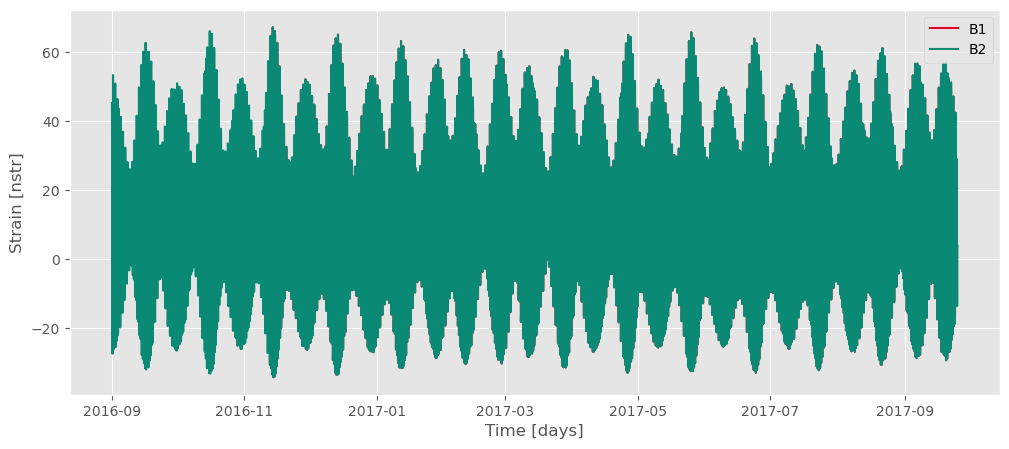

In [24]:
fig, ax = plt.subplots(nrows= 1,figsize=(12.0,5.0), sharex = True) # ,sharey=True

for i, key in enumerate(data):
    str_ = data[key]['strain']
    ax.plot(data[key].index, str_, label = key,color=myColor[i])

ax.set_ylabel("Strain [nstr]")
ax.set_xlabel("Time [days]")
ax.legend(loc="upper right")

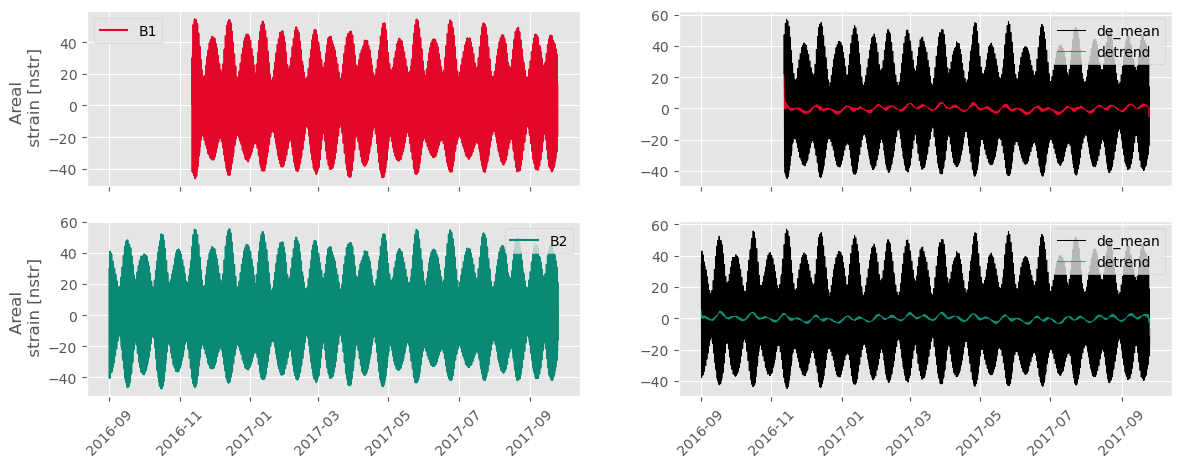

In [26]:
length = 3.0 # length of the detrend window
stopper = 3 # minimum number of samples in window
n_ovrlp = 5 # number of window overlaps

fig, ax = plt.subplots(nrows= len(data.keys()),ncols=2,figsize=(14.0,5.0), sharex = True) # ,sharey=True
dic_detr = {}

for j, key in enumerate(data):
    
    # create a new dataframe for the detrended data
    df_detr = pd.DataFrame(data[key].dnum, columns = ["dnum"])
    gw_col = np.array(['strain'])
    
    for name,i in zip(gw_col,range(len(gw_col))):
        gw = data[key][name]
        # detrending of the data
        df_detr[name] = hals.lin_window_ovrlp(data[key].dnum, gw.values,length=length,stopper=stopper,n_ovrlp=n_ovrlp)
        ax[j,0].plot(data[key].index,df_detr[name], label = key, color=myColor[j])
        ax[j,0].legend()
        ax[j,0].set_ylabel("Areal \n strain [nstr]")
        
        de_mean = gw.values - np.nanmean(gw.values)
        
        ax[j,1].plot(data[key].index, de_mean, label='de_mean', lw=0.75,color="black")
        ax[j,1].plot(data[key].index, de_mean - df_detr[name], label='detrend', lw=0.5, color=myColor[j])
        ax[j,1].legend(loc="upper right")       
    
    dic_detr[key] = df_detr

ax[j,0].tick_params(axis='x', labelrotation=45)
ax[j,1].tick_params(axis='x', labelrotation=45)   

In [28]:
# merge earth and atmospheric tide dictionaries
freqs = {**et_fqs, **at_fqs}
df_A = pd.DataFrame.from_dict(freqs,orient="index",columns=["freqs"])
df_phi = pd.DataFrame.from_dict(freqs,orient="index",columns=["freqs"])
df_complex = pd.DataFrame.from_dict(freqs,orient="index",columns=["freqs"])

for j, key in enumerate(data):
    
    # loop over the groundwater head measurement data sets
    #HALS function
    output = hals.hals_lsq(dic_detr[key].dnum.values, dic_detr[key]['strain'], list(freqs.values()))
    df_A[key] = output[0] #Amplitudes
    df_phi[key] = output[1] #Phases
    df_complex[key] = output[5] #Complex numbers
    
df_phi    

Conditioning number:  1.6890435014633067
Conditioning number:  1.4595125987027826


,freqs,B1,B2
Q1,0.893244,3.049392,1.961529
O1,0.929536,2.437366,-2.421588
M1,0.966446,-0.384129,-2.973289
P1,0.997262,1.201409,-2.823201
S1,1.000000,2.489986,2.837623
K1,1.002738,-0.285430,-0.468980
N2,1.895982,1.116679,-0.140270
M2,1.932274,0.528513,1.774351
S2,2.000000,-0.650475,1.472716
K2,2.005476,0.978204,0.650743


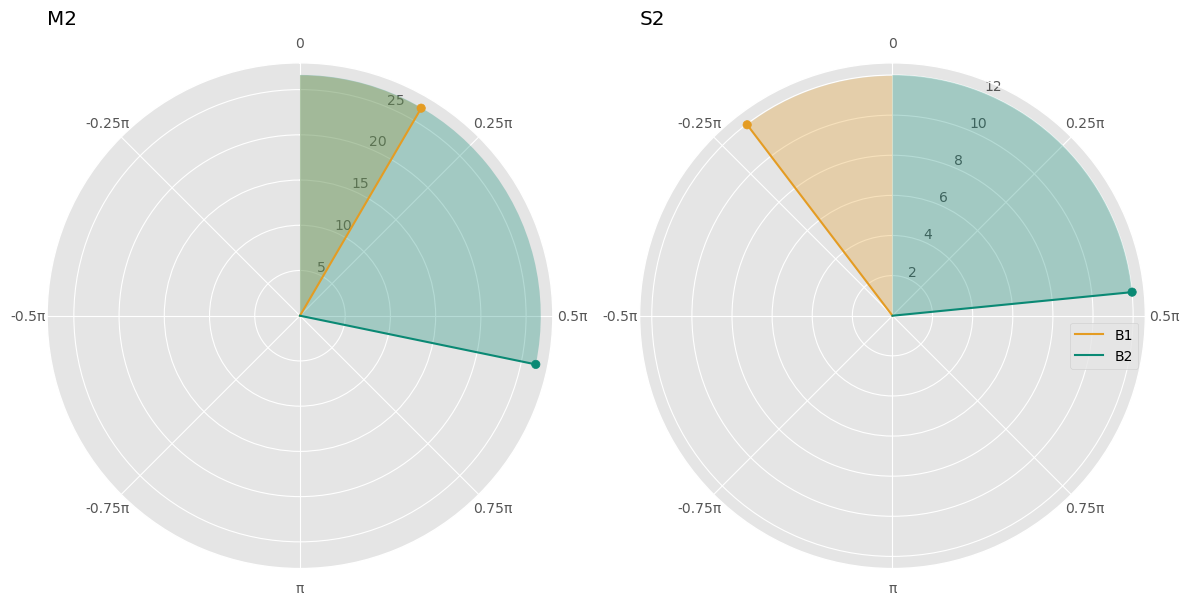

In [29]:
target = ["M2","S2"]
myColor  = ("#E49C23","#0A8974")

df_A = df_A.loc[target,data.keys()]
df_phi = df_phi.loc[target,data.keys()]

def radian_function(x, pos =None):
    # the function formatter sends
    rad_x = x/np.pi
    if rad_x == 0:
        return "0"
    if rad_x == 1:
        return "π"
    elif rad_x > 1:
        rad_x -= 2
        return "{}π".format(str(rad_x if rad_x % 1 else int(rad_x)))
    return "{}π".format(str(rad_x if rad_x % 1 else int(rad_x)))

fig = plt.figure(figsize=(12,12))

col = 1
for t in target:
    theta = df_phi.loc[t].values # angle
    amp = df_A.loc[t].values # amplitude
    
    amp = amp # convert to mm
    width = -theta # span
    
    ax = fig.add_subplot(1,2,col, polar=True)
    ax.bar(theta, amp, width=width, bottom=0.0, color=myColor, alpha=0.3,align="edge")
    ax.scatter(theta,amp, marker="o",color=myColor) #color=myColor[c]
        
        
    for i,j,c,l in zip(amp,theta,myColor,data.keys()):
        ax.plot([j]*2,[0,i],color=c,label=l)
        #print([j]*2,[0,i])
       # count = count +1
        

    ax.set_theta_zero_location("N") # orient north
    ax.set_theta_direction(-1) # reverse direction
    col+=1
    ax.set_title(t, va='bottom',loc="left")
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(radian_function))
    if t == target[-1]:
        ax.legend(bbox_to_anchor=(1.0, 0.5))
    
plt.tight_layout() 

In [30]:
results = {}

results['amp'] = df_A
results['phase'] = df_phi
results['complex'] = df_complex

# Save data

path = 'Results/pkl_files/'

with open(path + 'strain_to_atm_r.pkl', 'wb') as f:
    pickle.dump(results, f)